# Lunar Lander with Actor-Critic Method

### Solution to Questions of Lab7:
1. Why does the policy network has a softmax output (and the value network not?)
    - Because a policy networks outputs a probability distrubtion over all actions.
2. Why does the `select_action` method in cell 5 return two values?
    - The `action.item()` is for choosing the next action, while `m.log_prob(action)` is used for the training step.
3. Why do we need the `unsqueeze(0)` in the line `state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)` from cell 5
    - Because we need to add one dimension to make it a batch of states as input for the network.
4. Why is there a minus in `policy_loss = -log_prob * td_error` in cell 8.
    - Because we are doing gradient ascent instead of gradient descent.
5. Is there any exploration in the agent's action choice? If yes, in which code line?
    - The exploration is done by sampling from the probablity distribution when doing `action = m.sample()`.


In this notebook, we apply the actor-critic method to solve the cart pole environment.
Note: The original source of the much of the code can be found [here](https://medium.com/geekculture/actor-critic-implementing-actor-critic-methods-82efb998c273) and a blog post about it [here](https://medium.com/geekculture/actor-critic-implementing-actor-critic-methods-82efb998c273).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym
from tqdm import notebook
import numpy as np
from collections import deque

In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#Using a neural network to learn our policy parameters
class PolicyStateValueNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyStateValueNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer_policy = nn.Linear(128, action_space)
        self.output_layer_value = nn.Linear(128, 1)
    
    #forward pass
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer_policy(x)
        action_probs = F.softmax(actions, dim=1)
        state_value = self.output_layer_value(x)
        
        return action_probs, state_value

In [4]:
def select_action(network, state):

    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs, _ = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [5]:
#Make environment
env = gym.make('CartPole-v1')

state_count = env.observation_space.shape[0]
action_count = env.action_space.n

In [6]:

#Init network
policystatevalue_network = PolicyStateValueNetwork(state_count, action_count).to(DEVICE)

#Init optimizer
optimizer = optim.SGD(policystatevalue_network.parameters(), lr=0.001)

In [7]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 100)

#run episodes
for episode in notebook.tqdm(range(NUM_EPISODES)):
    
    #init variables
    state, _ = env.reset()
    done = False
    score = 0
    discount = 1
    
    #run episode, update online
    for step in range(MAX_STEPS):
        
        #get action and log probability
        action, log_prob = select_action(policystatevalue_network, state)
        
        #step with action
        new_state, reward, done, _, _ = env.step(action)
        
        #update episode score
        score += reward
        
        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        _, state_val = policystatevalue_network(state_tensor)
        
        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        _, new_state_val = policystatevalue_network(new_state_tensor)
        
        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        
        #calculate value function loss with MSE
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= discount
        
        #calculate policy loss
        td_error = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -log_prob * td_error
        policy_loss *= discount

        total_loss = policy_loss + val_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if done:
            break
            
        #move into new state, discount I
        state = new_state
        discount *= DISCOUNT_FACTOR
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)
    
    #early stopping if we meet solved score goal
    if np.array(recent_scores).mean() >= SOLVED_SCORE:
        break
        
        

  0%|          | 0/1000 [00:00<?, ?it/s]

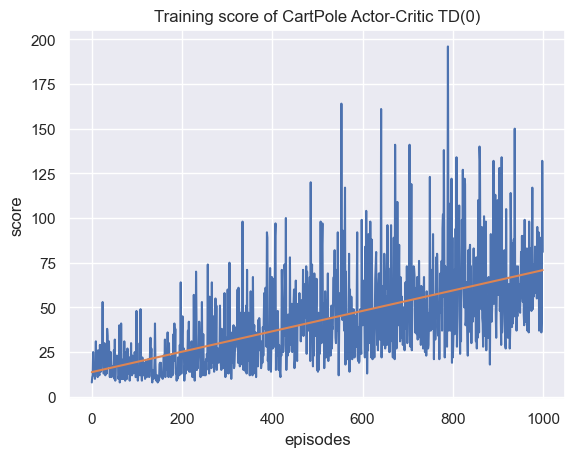

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole Actor-Critic TD(0)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

## Use the network to play some episodes

In [10]:
done = False
state, _ = env.reset()
scores = []

for _ in notebook.tqdm(range(50)):
    state, _ = env.reset()
    done = False
    score = 0
    while not done:
        action, lp = select_action(policystatevalue_network, state)
        new_state, reward, done, _, _ = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()
print("Mean reward earned:", np.mean(scores))

  0%|          | 0/50 [00:00<?, ?it/s]

Mean reward earned: 71.5
